In [98]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Data_Management'))) #We have a double .. as we are in the Strategy subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Risk_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Validation')))

# Import the modules
from data import Data
from calculations import Calculations, Metrics
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit
from manage_trade import Manage_Trade
from position import Position
from testing import WFO

Importing all_data.csv file for all types of data

In [99]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [100]:
start_time = dt.datetime(2020, 1, 1)
end_time = dt.datetime(2020, 9, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns         high  log_return  \
date                coin                                                      
2020-01-01 01:00:00 ADAUSDT      0.03299  1.006406      0.03303    0.006386   
                    BNBUSDT     13.79950  1.007402     13.80000    0.007375   
                    BTCUSDT   7216.27000  1.005469   7230.00000    0.005454   
                    ETHUSDT    130.64000  1.013735    130.65000    0.013641   
                    XRPUSDT      0.19371  1.006390      0.19372    0.006370   
...                                  ...       ...          ...         ...   
2020-08-31 23:00:00 ADAUSDT      0.12253  3.737950      0.12315    0.001634   
                    BNBUSDT     23.14770  1.689847     23.30670   -0.001407   
                    BTCUSDT  11649.51000  1.623168  11689.68000   -0.000161   
                    ETHUSDT    433.79000  3.366105    437.80000   -0.003061   
                    XRPUSDT      0.28115  1.460671      0.28359    0.000747   

                                     low         open        price   returns  \
date                coin                                                       
2020-01-01 01:00:00 ADAUSDT      0.03276      0.03277      0.03299  0.006406   
                    BNBUSDT     13.69530     13.69810     13.79950  0.007402   
                    BTCUSDT   7175.71000   7176.47000   7216.27000  0.005469   
                    ETHUSDT    128.78000    128.87000    130.64000  0.013735   
                    XRPUSDT      0.19237      0.19243      0.19371  0.006390   
...                                  ...          ...          ...       ...   
2020-08-31 23:00:00 ADAUSDT      0.12177      0.12233      0.12253  0.001635   
                    BNBUSDT     23.12460     23.17980     23.14770 -0.001406   
                    BTCUSDT  11647.61000  11651.39000  11649.51000 -0.000160   
                    ETHUSDT    433.70000    435.12000    433.79000 -0.003057   
                    XRPUSDT      0.28070      0.28095      0.28115  0.000747   

                                   volume  volume_in_dollars  
date                coin                                      
2020-01-01 01:00:00 ADAUSDT  1.560752e+06       5.148920e+04  
                    BNBUSDT  5.379125e+04       7.422924e+05  
                    BTCUSDT  8.830526e+02       6.372346e+06  
                    ETHUSDT  1.134466e+04       1.482066e+06  
                    XRPUSDT  2.339976e+06       4.532768e+05  
...                                   ...                ...  
2020-08-31 23:00:00 ADAUSDT  7.149835e+06       8.760693e+05  
                    BNBUSDT  7.473204e+04       1.729875e+06  
                    BTCUSDT  1.554036e+03       1.810376e+07  
                    ETHUSDT  3.991772e+04       1.731591e+07  
                    XRPUSDT  5.809346e+06       1.633297e+06  

[29215 rows x 10 columns]

---

In [101]:
def create_test_df(num_times: int = 5, num_coins: int = 10):
    """Creates a multi-index DataFrame for testing."""
    times = pd.to_datetime(['2024-01-01'] + [pd.Timestamp('2024-01-01') + pd.Timedelta(days=i) for i in range(1, num_times)])
    coins = [f"Coin_{i}" for i in range(num_coins)]
    index = pd.MultiIndex.from_product([times, coins], names=['time', 'coin'])
    
    df = pd.DataFrame(index=index)
    df['above_ema'] = np.random.choice([True, False], size=len(df))
    df['volume_rank'] = np.random.randint(1, 100, size=len(df))
    df['std_rank'] = np.random.randint(1, 10, size=len(df))
    df['entry_signal'] = np.random.randint(0, 2, size=len(df)) # 0 or 1
    df['position'] = np.random.randint(0, 2, size=len(df))
    return df

# Example usage to create a test DataFrame:
test_df = create_test_df(num_times=4, num_coins=8)
test_df.head()

above_ema  volume_rank  std_rank  entry_signal  position
time       coin                                                            
2024-01-01 Coin_0       True           38         9             0         1
           Coin_1       True           67         8             1         0
           Coin_2      False            9         4             1         0
           Coin_3       True           30         3             1         0
           Coin_4       True           96         7             0         1

In [102]:
import pandas as pd
import numpy as np
from typing import Set, List
import pandas as pd
from typing import List


def update_universe(df: pd.DataFrame, max_positions: int = 4, low_freq = '1d') -> pd.Series:
    """
    Updates a DataFrame to track a dynamic universe of coins.
    Should include the dataframe with the lower frequency data. (daily, weekly, etc.)
    Assumes a stacked dataframe
    """
    current_universe = set()
    df['in_universe'] = False

    for time_index in df.index.get_level_values(0).unique():
        # Remove coins that are no longer in the universe *for this time index*
        coins_to_remove = []
        for coin in current_universe:
            if (time_index, coin) in df.index and df.loc[(time_index, coin), 'position'] == 0:
                coins_to_remove.append(coin)
                df.loc[(time_index, coin), 'in_universe'] = False
        current_universe.difference_update(coins_to_remove) #use difference_update for set manipulation


        current_coins = df.loc[time_index].index
        available_coins = set(current_coins) - current_universe

        if len(current_universe) < max_positions and available_coins:
            temp_df = df.loc[(time_index, list(available_coins)), :].copy()

            # The shift was the main source of the bug. It was shifting across coins,
            # which is incorrect. We should not shift at all in this context.
            # The intention was likely to use the *previous* time slice data.
            # This is handled later.

            filter_condition = (
                (temp_df['above_ema']) &
                (temp_df['volume_rank'] < 50) &
                (temp_df['std_rank'] < 10) &
                (temp_df['entry_signal'] == 1)
            )

            potential_coins_df = temp_df[filter_condition]

            if not potential_coins_df.empty:
                potential_coins_df = potential_coins_df.sort_values(by='std_rank')
                potential_coins = set(potential_coins_df.index.get_level_values(1))
                missing_positions = max_positions - len(current_universe)
                to_be_added: List[str] = list(potential_coins)[:missing_positions]
                current_universe.update(to_be_added)

        df.loc[(time_index, list(current_universe)), 'in_universe'] = True
    
    df = df.unstack()
    df['in_universe'] = df['in_universe'].shift(periods = 1, freq = low_freq)
    df = df.stack()
    return df['in_universe'], current_universe

test_df['in_universe'], current_universe = update_universe(test_df)

print(current_universe)
test_df

{'Coin_6', 'Coin_7', 'Coin_3'}


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


above_ema  volume_rank  std_rank  entry_signal  position  \
time       coin                                                               
2024-01-01 Coin_0       True           38         9             0         1   
           Coin_1       True           67         8             1         0   
           Coin_2      False            9         4             1         0   
           Coin_3       True           30         3             1         0   
           Coin_4       True           96         7             0         1   
           Coin_5       True           70         6             0         0   
           Coin_6      False           76         1             1         1   
           Coin_7       True            4         1             1         0   
2024-01-02 Coin_0      False           35         8             1         1   
           Coin_1      False            2         8             0         1   
           Coin_2      False           77         5             0         0   
           Coin_3      False           65         3             0         1   
           Coin_4      False            1         1             1         0   
           Coin_5       True           35         7             0         0   
           Coin_6      False           28         7             1         1   
           Coin_7      False            3         3             0         1   
2024-01-03 Coin_0      False           24         6             0         1   
           Coin_1       True           11         6             0         0   
           Coin_2       True           99         9             1         1   
           Coin_3       True           89         3             1         0   
           Coin_4       True           65         5             0         0   
           Coin_5      False           29         2             0         0   
           Coin_6       True           33         9             0         1   
           Coin_7       True           50         3             1         1   
2024-01-04 Coin_0       True           86         8             1         0   
           Coin_1      False           40         2             1         1   
           Coin_2       True           53         7             1         1   
           Coin_3       True            3         7             1         0   
           Coin_4      False           97         6             0         1   
           Coin_5      False            6         6             0         0   
           Coin_6       True           13         7             1         0   
           Coin_7      False           60         3             0         1   

                  in_universe  
time       coin                
2024-01-01 Coin_0         NaN  
           Coin_1         NaN  
           Coin_2         NaN  
           Coin_3         NaN  
           Coin_4         NaN  
           Coin_5         NaN  
           Coin_6         NaN  
           Coin_7         NaN  
2024-01-02 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3        True  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7        True  
2024-01-03 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3        True  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7        True  
2024-01-04 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7        True

In [103]:
###### To Optimize ######
#All parameters:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling
low_freq_index = 1 #The index of the lowest frequency for the resampling
low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
max_dollar_allocation = 10000
std_window = 2
mean_window = 2
ema_window = 2
high_freq_index = 3 #The index of the highest frequency for the resampling
high_freq = all_frequency[high_freq_index] #The highest frequency for the resampling
hourly_lookback = 1
daily_lookback= 1
_min_pos = 0
_max_pos = 1
sl_type = 'atr'
sl_ind_length = 14
sl_ind_mult = 3
sl_signal_only = True
fixed_sl = True
tp_type = 'rr'
tp_mult = 2
tp_ind_length = 0
tp_signal_only = True
fixed_tp = True
max_perc_risk = 0.01




#Downsample the data
cal = Calculations()
#Generate a signal
mr = Mean_Reversion()

_df = mr.last_days_low(data, hourly_lookback, daily_lookback)


_df

close  creturns         high  log_return  \
date                coin                                                      
2020-01-01 01:00:00 ADAUSDT      0.03299  1.006406      0.03303    0.006386   
                    BNBUSDT     13.79950  1.007402     13.80000    0.007375   
                    BTCUSDT   7216.27000  1.005469   7230.00000    0.005454   
                    ETHUSDT    130.64000  1.013735    130.65000    0.013641   
                    XRPUSDT      0.19371  1.006390      0.19372    0.006370   
...                                  ...       ...          ...         ...   
2020-08-31 23:00:00 ADAUSDT      0.12253  3.737950      0.12315    0.001634   
                    BNBUSDT     23.14770  1.689847     23.30670   -0.001407   
                    BTCUSDT  11649.51000  1.623168  11689.68000   -0.000161   
                    ETHUSDT    433.79000  3.366105    437.80000   -0.003061   
                    XRPUSDT      0.28115  1.460671      0.28359    0.000747   

                                     low         open        price   returns  \
date                coin                                                       
2020-01-01 01:00:00 ADAUSDT      0.03276      0.03277      0.03299  0.006406   
                    BNBUSDT     13.69530     13.69810     13.79950  0.007402   
                    BTCUSDT   7175.71000   7176.47000   7216.27000  0.005469   
                    ETHUSDT    128.78000    128.87000    130.64000  0.013735   
                    XRPUSDT      0.19237      0.19243      0.19371  0.006390   
...                                  ...          ...          ...       ...   
2020-08-31 23:00:00 ADAUSDT      0.12177      0.12233      0.12253  0.001635   
                    BNBUSDT     23.12460     23.17980     23.14770 -0.001406   
                    BTCUSDT  11647.61000  11651.39000  11649.51000 -0.000160   
                    ETHUSDT    433.70000    435.12000    433.79000 -0.003057   
                    XRPUSDT      0.28070      0.28095      0.28115  0.000747   

                                   volume  volume_in_dollars  \
date                coin                                       
2020-01-01 01:00:00 ADAUSDT  1.560752e+06       5.148920e+04   
                    BNBUSDT  5.379125e+04       7.422924e+05   
                    BTCUSDT  8.830526e+02       6.372346e+06   
                    ETHUSDT  1.134466e+04       1.482066e+06   
                    XRPUSDT  2.339976e+06       4.532768e+05   
...                                   ...                ...   
2020-08-31 23:00:00 ADAUSDT  7.149835e+06       8.760693e+05   
                    BNBUSDT  7.473204e+04       1.729875e+06   
                    BTCUSDT  1.554036e+03       1.810376e+07   
                    ETHUSDT  3.991772e+04       1.731591e+07   
                    XRPUSDT  5.809346e+06       1.633297e+06   

                             shifted_htf_open  shifted_htf_high  \
date                coin                                          
2020-01-01 01:00:00 ADAUSDT               NaN               NaN   
                    BNBUSDT               NaN               NaN   
                    BTCUSDT               NaN               NaN   
                    ETHUSDT               NaN               NaN   
                    XRPUSDT               NaN               NaN   
...                                       ...               ...   
2020-08-31 23:00:00 ADAUSDT           0.11624           0.11879   
                    BNBUSDT          22.94410          23.83000   
                    BTCUSDT       11465.84000       11719.00000   
                    ETHUSDT         398.65000         429.89000   
                    XRPUSDT           0.27375           0.28389   

                             shifted_htf_low  shifted_htf_close  \
date                coin                                          
2020-01-01 01:00:00 ADAUSDT              NaN                NaN   
                    BNBUSDT              NaN                

In [104]:
_df['entry_signal'].value_counts()

entry_signal
0    29068
1      147
Name: count, dtype: int64

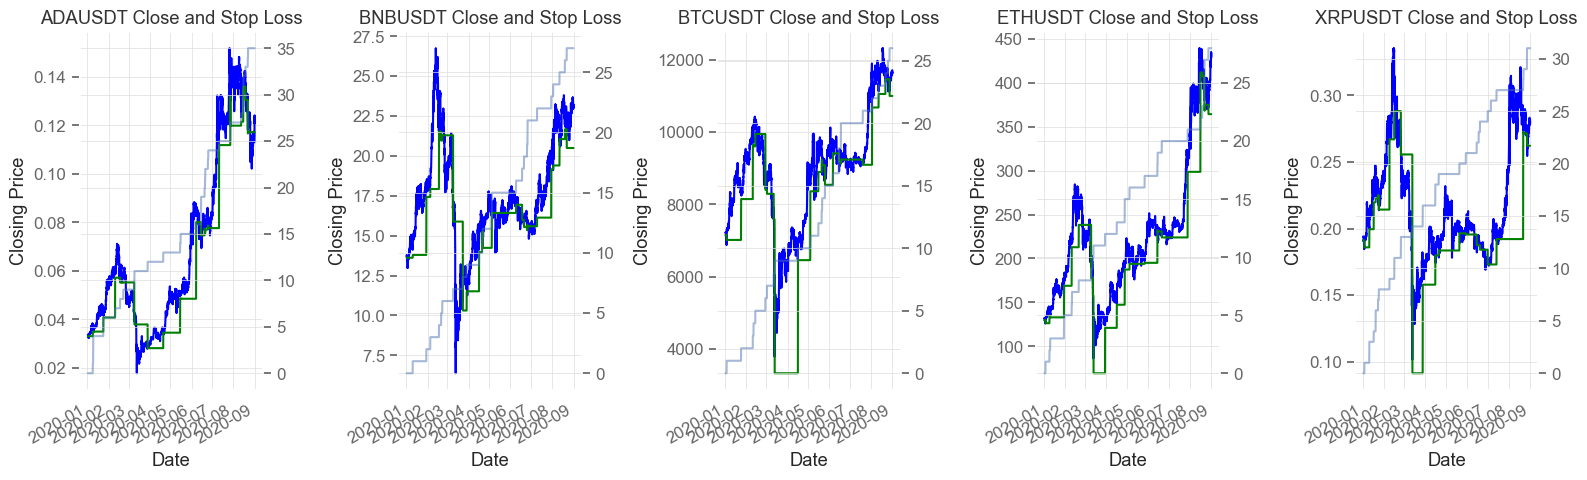

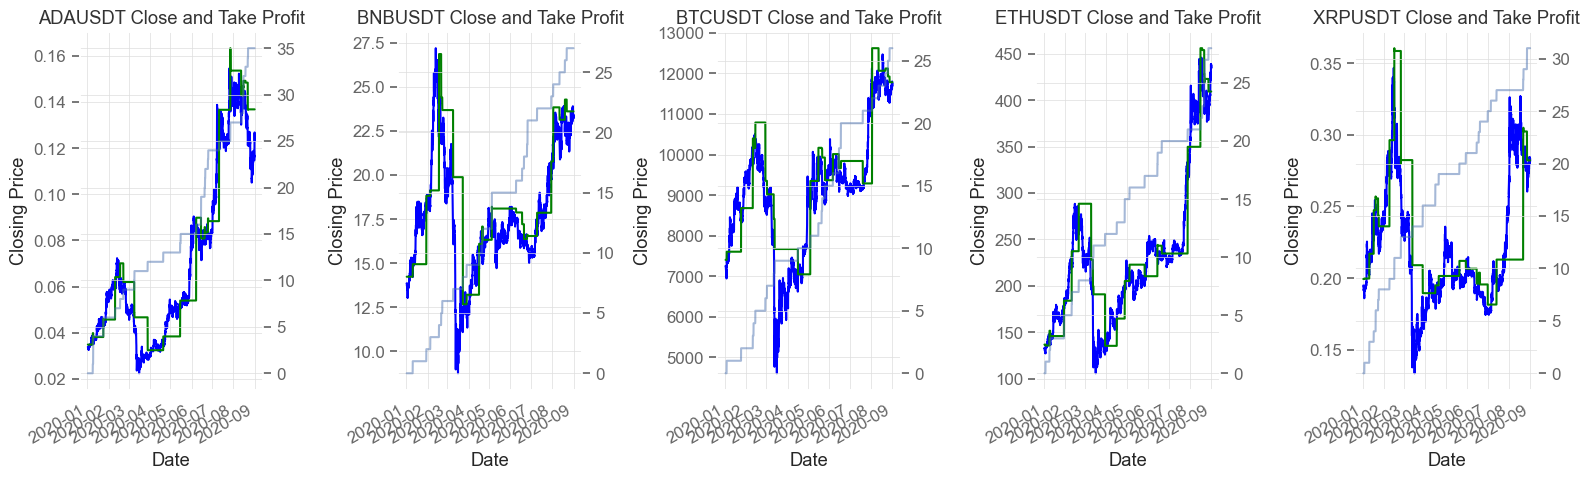

In [105]:
pos = Position(_df, _min_pos, _max_pos)
_df = pos.initialize_position()
sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
_df = sl.apply_stop_loss(fixed_sl, plot = True)
tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
_df = tp.apply_take_profit(fixed_tp, plot = True)

_df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
_df = pos.calculate_position(_df)

mt = Manage_Trade(_df)
_df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

#########################

_df = cal.update_all(_df)

In [106]:
_df['position'].to_frame()

position
date                coin             
2020-01-01 15:00:00 ADAUSDT       NaN
                    BNBUSDT       NaN
                    BTCUSDT       NaN
                    ETHUSDT       NaN
                    XRPUSDT       NaN
...                               ...
2020-08-31 23:00:00 ADAUSDT       0.0
                    BNBUSDT       0.0
                    BTCUSDT       0.0
                    ETHUSDT       0.0
                    XRPUSDT       0.0

[29145 rows x 1 columns]

In [107]:
df = cal.downsample(_df, low_freq)

In [108]:

#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(df, max_dollar_allocation)

In [109]:
df = coarse.sort_by_volume(df)

In [110]:
df = coarse.sort_by_std(df, std_window, mean_window)

In [111]:
fine = Fine()
df = fine.above_ema(df, ema_window)

In [112]:
#apply update_univers
df['in_universe'], current_universe = update_universe(df)

C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [113]:
df.dropna()

close  creturns         high  log_return  \
date                coin                                                      
2020-01-02 00:00:00 ADAUSDT      0.03343  1.019829      0.03348   -0.001495   
                    BNBUSDT     13.71230  1.001037     13.73020   -0.000445   
                    BTCUSDT   7211.02000  1.004737   7212.50000    0.001411   
                    ETHUSDT    130.67000  1.013968    130.78000   -0.000765   
                    XRPUSDT      0.19292  1.002286      0.19304   -0.000674   
...                                  ...       ...          ...         ...   
2020-08-31 23:00:00 ADAUSDT      0.12253  3.737950      0.12315    0.001634   
                    BNBUSDT     23.14770  1.689847     23.30670   -0.001407   
                    BTCUSDT  11649.51000  1.623168  11689.68000   -0.000161   
                    ETHUSDT    433.79000  3.366105    437.80000   -0.003061   
                    XRPUSDT      0.28115  1.460671      0.28359    0.000747   

                                     low         open        price   returns  \
date                coin                                                       
2020-01-02 00:00:00 ADAUSDT      0.03340      0.03345      0.03343 -0.001493   
                    BNBUSDT     13.67060     13.70720     13.71230 -0.000445   
                    BTCUSDT   7185.46000   7200.77000   7211.02000  0.001412   
                    ETHUSDT    130.27000    130.72000    130.67000 -0.000765   
                    XRPUSDT      0.19246      0.19304      0.19292 -0.000673   
...                                  ...          ...          ...       ...   
2020-08-31 23:00:00 ADAUSDT      0.12177      0.12233      0.12253  0.001635   
                    BNBUSDT     23.12460     23.17980     23.14770 -0.001406   
                    BTCUSDT  11647.61000  11651.39000  11649.51000 -0.000160   
                    ETHUSDT    433.70000    435.12000    433.79000 -0.003057   
                    XRPUSDT      0.28070      0.28095      0.28115  0.000747   

                                   volume  volume_in_dollars  ...  \
date                coin                                      ...   
2020-01-02 00:00:00 ADAUSDT  1.020309e+06       3.410894e+04  ...   
                    BNBUSDT  5.083784e+04       6.971037e+05  ...   
                    BTCUSDT  3.913524e+02       2.822050e+06  ...   
                    ETHUSDT  3.772667e+03       4.929744e+05  ...   
                    XRPUSDT  9.287867e+05       1.791815e+05  ...   
...                                   ...                ...  ...   
2020-08-31 23:00:00 ADAUSDT  7.149835e+06       8.760693e+05  ...   
                    BNBUSDT  7.473204e+04       1.729875e+06  ...   
                    BTCUSDT  1.554036e+03       1.810376e+07  ...   
                    ETHUSDT  3.991772e+04       1.731591e+07  ...   
                    XRPUSDT  5.809346e+06       1.633297e+06  ...   

                               htf_close    htf_volume  htf_volume_in_dollars  \
date                coin                                                        
2020-01-02 00:00:00 ADAUSDT      0.03269  4.282646e+07           1.405664e+06   
                    BNBUSDT     13.01050  9.711907e+05           1.298722e+07   
                    BTCUSDT   6965.71000  3.195148e+04           2.258280e+08   
                    ETHUSDT    127.19000  2.137571e+05           2.749587e+07   
                    XRPUSDT      0.18750  4.791211e+07           9.081044e+06   
...                                  ...           ...                    ...   
2020-08-31 23:00:00 ADAUSDT      0.12253  4.592725e+08           5.525868e+07   
                    BNBUSDT     23.14770  1.767388e+06           4.125484e+07   
                    BTCUSDT  11649.51000  5.535362e+04           6.464956e+08   
                    ETHUSDT    433.79000  1.040749e+06           4.478154e+08   
                    XRPUSDT      0.28115  1.645416e+08           4.630695e+07   

              

<Axes: xlabel='date,coin'>

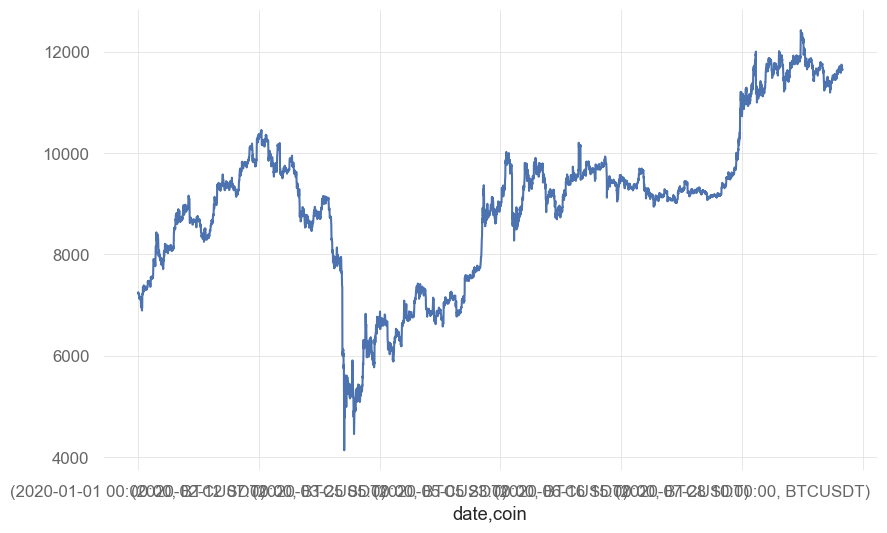

In [114]:
df.loc[(slice(None), 'BTCUSDT'), 'close'].plot()


In [115]:
df.dropna(inplace = True)

In [116]:
df = df[df['in_universe']]

In [117]:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling 

In [118]:
def trading_strategy(
        data,
        params = None,
        ###### To Optimize ######
        std_window = 20,
        mean_window = 20,
        ema_window = 20,
        hourly_lookback = 1,
        daily_lookback= 1,
        _min_pos = 0, #Has to be >= 0
        _max_pos = 1, #Has to be > 0
        sl_ind_length = 14,
        sl_ind_mult = 3,
        tp_mult = 2,
        ptp_mult = 1,
        ptp_exit_percent = 0.5,
        ###### Constants ######
        low_freq_index = 1, #The index of the lowest frequency for the resampling
        high_freq_index = 3, #The index of the highest frequency for the resampling
        max_perc_risk = 0.01,
        max_dollar_allocation = 10000,
        sl_type = 'atr',
        tp_type = 'rr',
        sl_signal_only = True,
        tp_signal_only = True,
        ptp_signal_only = True,
        tp_ind_length = 0,
        fixed_sl = True,
        fixed_tp = True
        ):
    
    if params is not None:
        if isinstance(params, list):
            std_window = params[0]
            mean_window = params[1]
            ema_window = params[2]
            hourly_lookback = params[3]
            daily_lookback = params[4]
            _min_pos = params[5]
            _max_pos = params[6]
            sl_ind_length = params[7]
            sl_ind_mult = params[8]
            tp_mult = params[9]
            ptp_mult = params[10]
            ptp_exit_percent = params[11]
        if isinstance(params, dict):
            std_window = params['std_window']
            mean_window = params['mean_window']
            ema_window = params['ema_window']
            hourly_lookback = params['str_length']
            daily_lookback = params['str_mult']
            _min_pos = params['_min_pos']
            _max_pos = params['_max_pos']
            sl_ind_length = params['sl_ind_length']
            sl_ind_mult = params['sl_ind_mult']
            tp_mult = params['tp_mult']
            ptp_mult = params['ptp_mult']
            ptp_exit_percent = params['ptp_exit_percent']
        


    if high_freq_index > low_freq_index:
        low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
        high_freq = all_frequency[high_freq_index], #The highest frequency for the resampling
            #Generally not going to be used since we are not calling the data inside the function
    
    
    cal = Calculations()
    mr = Mean_Reversion()
    #Generate a signal
    

    _df = mr.last_days_low(data.copy(), hourly_lookback, daily_lookback)


    pos = Position(_df, _min_pos, _max_pos)
    _df = pos.initialize_position()
    sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
    _df = sl.apply_stop_loss(fixed_sl, plot = False)
    tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
    _df = tp.apply_take_profit(fixed_tp, plot = False)
    ptp = Take_Profit(_df, tp_type, ptp_mult, ptp_signal_only, exit_percent = ptp_exit_percent)
    _df = ptp.apply_take_profit(fixed_tp, plot = False)
    

    _df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
    _df = pos.calculate_position(_df)

    mt = Manage_Trade(_df)
    _df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

    #########################

    _df = cal.update_all(_df)

    #Downsample the data
    df = cal.downsample(_df, low_freq)

    #Perform coarse analysis and filtering
    coarse = Coarse()
    df = coarse.volume_flag(df, max_dollar_allocation)
    df = coarse.sort_by_volume(df)
    df = coarse.sort_by_std(df, std_window, mean_window)
    fine = Fine()
    df = fine.above_ema(df, ema_window)

    #apply update_universe
    df['in_universe'], current_universe = update_universe(df)

    df.dropna(inplace = True)

    df = df[df['in_universe']]

    return df



In [119]:
sample_strategy = trading_strategy(data)
'strategy' in sample_strategy.columns

C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


True

In [120]:
sample_strategy

,,close,creturns,high,log_return,low,open,price,returns,volume,volume_in_dollars,...,htf_close,htf_volume,htf_volume_in_dollars,volume_flag,volume_rank,htf_std_values,std_rank,ema_20,above_ema,in_universe
date,coin,,,,,,,,,,,,,,,,,,,,,
2020-01-17 17:00:00,XRPUSDT,0.23845,1.238830,0.23850,0.012916,0.23481,0.23539,0.238162,0.013000,8.001190e+06,1.907884e+06,...,0.23921,2.143690e+08,5.056137e+07,1,2.0,0.013194,3.0,0.233358,1,True
2020-01-17 18:00:00,XRPUSDT,0.24228,1.258728,0.24289,0.015934,0.23812,0.23845,0.242280,0.016062,2.019166e+07,4.892036e+06,...,0.23921,2.143690e+08,5.056137e+07,1,2.0,0.009564,3.0,0.234208,1,True
2020-01-17 19:00:00,XRPUSDT,0.23742,1.233479,0.24453,-0.020263,0.23149,0.24220,0.237420,-0.020059,2.576879e+07,6.118027e+06,...,0.23921,2.143690e+08,5.056137e+07,1,2.0,0.000000,3.0,0.234514,1,True
2020-01-17 20:00:00,XRPUSDT,0.23708,1.231712,0.23957,-0.001433,0.23609,0.23742,0.237080,-0.001432,9.394550e+06,2.227260e+06,...,0.23921,2.143690e+08,5.056137e+07,1,2.0,0.000000,3.0,0.234758,1,True
2020-01-17 21:00:00,XRPUSDT,0.24009,1.247350,0.24010,0.012616,0.23626,0.23708,0.240090,0.012696,5.551760e+06,1.332922e+06,...,0.23921,2.143690e+08,5.056137e+07,1,2.0,0.000000,3.0,0.235266,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-22 20:00:00,BTCUSDT,11609.31000,1.617567,11611.00000,0.001642,11570.27000,11590.26000,11609.310000,0.001644,1.205633e+03,1.399657e+07,...,11662.96000,4.367870e+04,5.044518e+08,1,5.0,0.000000,3.0,11588.764134,1,True
2020-08-22 21:00:00,BTCUSDT,11667.02000,1.625608,11680.00000,0.004959,11598.45000,11609.31000,11667.020000,0.004971,1.634757e+03,1.907274e+07,...,11662.96000,4.367870e+04,5.044518e+08,1,5.0,0.000000,3.0,11596.217074,1,True
2020-08-22 22:00:00,BTCUSDT,11664.15000,1.625208,11684.78000,-0.000246,11642.00000,11667.01000,11664.150000,-0.000246,1.554440e+03,1.813122e+07,...,11662.96000,4.367870e+04,5.044518e+08,1,5.0,0.000000,3.0,11602.686876,1,True


In [121]:
# Define parameter space for optimization
param_space = {
    'std_window': Integer(5, 30),
    'mean_window': Integer(5, 30),
    'ema_window': Integer(5, 100),
    'hourly_lookback': Integer(1, 3),
    'daily_lookback': Integer(1, 3),
    '_min_pos': Real(0, 0.25),
    '_max_pos': Real(0, 1.5),
    'sl_ind_length': Integer(5, 50),
    'sl_ind_mult': Real(0.5, 5),
    'tp_mult': Integer(1, 2),
    'ptp_mult': Real(0.5, 1),
    'ptp_exit_percent': Real(0.1, 1)
    
    
}

In [122]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
from skopt import gp_minimize
from skopt.space import Integer, Categorical, Real
import quantstats_lumi as qs
from collections.abc import Iterable




class WFO():
    def __init__(self, data, 
                 trading_strategy, 
                 param_grid = {}, 
                 train_size = 1000, 
                 test_size = 1000, 
                 step_size = 1000, 
                 optimize_fn="grid",
                 objective = 'sharpe',
                 opt_freq = 'custom'):
        """
        This class performs a walk-forward optimization on a trading strategy.

        Parameters:
        data (pd.DataFrame): The historical data to be used for backtesting.
        trading_strategy (object): The trading strategy to be optimized.
        param_grid (dict): The grid of parameters to be optimized.
        train_size (int): The number of data points to be used for training.
        test_size (int): The number of data points to be used for testing.
        step_size (int): The number of data points to step forward in each iteration.
        optimize_fn (str): The optimization function to use ("grid" or "gp").
        objective (str): The objective function to maximize ("sharpe", "sortino", "calmar", "multiple").
        opt_period (str): The period to optimize over ['custom', 'daily', 'weekly', 'quarterly', 'semi-annually', 'yearly'].
        """
        self.data = data
        self.trading_strategy = trading_strategy
        self.param_grid = param_grid
        if opt_freq == 'custom':
            self.train_size = train_size
        else:
            self.train_size = train_size = self.opt_freq(opt_freq)
        self.test_size = test_size
        self.step_size = step_size
        self.optimize_fn = optimize_fn
        self.objective = objective
        
        if train_size > 0:
            self.minimum_train_size = self.min_train_test_size(train_size)
        else:
            raise ValueError("Train size must be greater than 0.")

        max_param = max(
        param.high if isinstance(param, (Integer, Real)) else max(param) #To handle all different cases
        for param in param_grid.values()
        )

        if step_size + train_size + test_size > len(data):
            raise ValueError("Invalid train, test, or step size.")
        elif (train_size < max_param or test_size < max_param):
            raise ValueError("Parameter range exceeds train size or Test size.")
        elif train_size < 1 or test_size < 1 or step_size < 1:
            raise ValueError("Train, test, and step size must be greater than 0.")
        elif test_size < train_size:
            raise ValueError("Test size must be greater or equal to train size.")
        #It is kind of wrong to say this because data can be empty because there are no trades or no universe
        # elif self.minimum_train_size > train_size:
        #     train_size = self.minimum_train_size
        #     print(f"Adjusted train size to {train_size}")
    
        if optimize_fn not in ["grid", "gp"]:
            raise ValueError("Invalid optimization function")
        
                             

    #### Helper Methods ####
    def min_train_test_size(self, train_size):
        """
        Calculate the minimum test size based on the train size.
        """

        current_size = train_size
        result = []

        while len(result) == 0 or result is None:
            result = self.trading_strategy(self.data.iloc[:current_size])
            if len(result) != 0:
                break
            current_size *= 2
            

        return current_size - len(result)


        
    def dict_to_param_space(self, param_dict):
        """
        Converts a dictionary of parameters to a list of skopt parameters.
        """
        param_space = []
        for param_name, param_range in param_dict.items():
            if isinstance(param_range, Integer):
                param_space.append(Integer(param_range.low, param_range.high, name=param_name))
            elif isinstance(param_range, Real):
                param_space.append(Real(param_range.low, param_range.high, name=param_name))
            elif isinstance(param_range, Categorical):
                param_space.append(Categorical(param_range.categories, name=param_name))
            elif isinstance(param_range, range):
                param_space.append(Integer(min(param_range), max(param_range), name=param_name))
            else:
                raise ValueError(f"Invalid range for parameter '{param_name}': {param_range}")
        return param_space
        

    def convert_param_space(self, param_space, n_samples=10):
        """
        Converts a parameter dictionary with Integer and Real objects to an iterable format.

        Parameters:
            param_space (dict): Dictionary with Integer or Real objects as values.
            n_samples (int): Number of discrete samples to generate for Real values.
        
        Returns:
            dict: Parameter dictionary with iterable values.
        """
        converted = {}
        for key, value in param_space.items():
            if isinstance(value, Integer):
                # Generate a range of discrete integers
                converted[key] = list(range(value.low, value.high + 1))
            elif isinstance(value, Real):
                # Generate n_samples equally spaced values in the range
                converted[key] = list(np.linspace(value.low, value.high, n_samples))
            else:
                # Assume the parameter is already iterable
                converted[key] = value

        return converted

    

    def split_data(self, data, train_size, test_size, step_size):
        start = 0
        while start + train_size + test_size <= len(data):
            train = data.iloc[start:start + train_size]
            test = data.iloc[start + train_size:start + train_size + test_size]
            yield train, test
            start += step_size

    def objective_function(self, result):
        """
        Calculate the objective function for the optimization.

        Note that we have only included objective functions that we want to maximize.
        """
        if 'strategy' not in result.columns:
            print("No strategy column in result")
            return 0

        strategy = result['strategy'].apply(np.exp) - 1

        if strategy.sum() == 0:
            return 0

        try:
            if self.objective == "multiple":
                creturns = result['strategy'].cumsum().apply(np.exp)
                performance = creturns.iloc[-1]
            elif self.objective == "sharpe":
                performance = qs.stats.sharpe(strategy)
            elif self.objective == "sortino":
                performance = qs.stats.sortino(strategy)
            elif self.objective == "calmar": 
                performance = qs.stats.calmar(strategy)
            else:
                raise ValueError("Invalid objective function")
        except Exception as e:
            print(f"Error calculating performance: {e}")
            performance = 0

        return performance
    
    def opt_freq(self, opt_freq):
        time_diff = self.data.unstack().index.get_level_values(0)[1] - self.data.unstack().index.get_level_values(0)[0]

        if opt_freq == 'daily':
            return pd.Timedelta('1 day') // time_diff
        elif opt_freq == 'weekly':
            return pd.Timedelta('1 w') // time_diff
        elif opt_freq == 'monthly':
            return pd.Timedelta('1 m') // time_diff
        elif opt_freq == 'quarterly':
            return pd.Timedelta('3 m') // time_diff
        elif opt_freq == 'semi-annually':
            return pd.Timedelta('6 m') // time_diff
        elif opt_freq == 'yearly':
            return pd.Timedelta('1 y') // time_diff
        else:
            raise ValueError("Invalid optimization frequency")
    
    



    #### Optimization Methods ####
    def optimize_parameters_grid(self, train_data, param_space):
        #Check if the parameter space is iterable (for ParameterGrid compatibility)
        if not any([isinstance(param_range, Iterable) for param_range in param_space.values()]):
            param_grid = self.convert_param_space(param_space, n_samples=20)
        else:
            param_grid = param_space
        
        print([param_space])
        best_params = None
        best_objective = -np.inf
        for params in ParameterGrid(param_grid):
            print(params)
            # print(train_data)
            result = self.trading_strategy(train_data.copy(), params = params)
            if result is None or len(result) == 0:
                continue
            # print(result)
            objective = self.objective_function(result)
            print(objective)
            if objective > best_objective:
                best_objective = objective
                best_params = params
        return best_params

    def optimize_parameters_gp(self, train_data, param_space):

        if isinstance(param_space, dict):
            param_space = self.dict_to_param_space(param_space)

        def objective(param_space):
            result = self.trading_strategy(train_data.copy(), params = param_space)
            # Use negative performance because gp_minimize minimizes
            objective = self.objective_function(result) 
            print(objective)
            return -objective if not pd.isnull(objective) else 1e10  # Handle invalid values

        # Run gp_minimize
        result = gp_minimize(
            func=objective,
            dimensions=param_space,
            n_calls=10,  # Number of evaluations
            random_state=42,
        )
        
        # Extract the best parameters
        best_params = {dim.name: val for dim, val in zip(param_space, result.x)}
        print(best_params)
        print(result.x)
        return best_params

   
    def test_strategy(self, test_data, best_params):
        result = self.trading_strategy(test_data.copy(), **best_params)
        peformance = self.objective_function(result)
        return peformance, result


    def walk_forward_optimization(self):
        """
        Perform a walk-forward optimization on a dataset.
        """
        all_performance = []
        all_results = []
        for train, test in self.split_data(self.data, self.train_size, self.test_size, self.step_size):
            # Optimize on training data
            if self.optimize_fn == "grid":
                best_params = self.optimize_parameters_grid(train, self.param_grid)
            elif self.optimize_fn == "gp":
                best_params = self.optimize_parameters_gp(train, self.param_grid)
            
            # Test on out-of-sample data
            performance, result = self.test_strategy(test, best_params)
            print(f"Out-of-sample performance: {performance}")
            
            all_performance.append(performance)
            all_results.append(result)
        
        all_results = pd.concat(all_results)
        return all_performance, all_results


In [93]:
wfo = WFO(data, 
            trading_strategy, 
            param_space, 
            train_size=2000, 
            test_size=2000, 
            step_size=2000, 
            optimize_fn="gp", 
            objective='multiple', 
            opt_freq='custom')

all_performance, all_results = wfo.walk_forward_optimization()

C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()
C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()
C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this w

0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9999932948375532


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0524327228809613


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0313157644722188


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 7, 'mean_window': 20, 'ema_window': 41, 'hourly_lookback': 3, 'daily_lookback': 2, '_min_pos': 0.2149851016840802, '_max_pos': 1.0204613078816698, 'sl_ind_length': 25, 'sl_ind_mult': 0.5596923252193994, 'tp_mult': 2, 'ptp_mult': 0.7816441089227697, 'ptp_exit_percent': 0.4468748522859246}
[7, 20, 41, 3, 2, 0.2149851016840802, 1.0204613078816698, 25, 0.5596923252193994, 2, 0.7816441089227697, 0.4468748522859246]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 1.042601109367121


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0097216766292192


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0020617404885492


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.042601109367121


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.034892101802211


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0398103406978618


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0119580388753815


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0888004882794544


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.066940321100067


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0149768337856067
{'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'hourly_lookback': 3, 'daily_lookback': 2, '_min_pos': 0.2315752196283373, '_max_pos': 0.9766155382529169, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 1, 'ptp_mult': 0.5477050582452057, 'ptp_exit_percent': 0.43373642697843984}
[5, 10, 73, 3, 2, 0.2315752196283373, 0.9766155382529169, 46, 4.325173600054098, 1, 0.5477050582452057, 0.43373642697843984]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0666719656858752


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0060927233644232


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9422764424879362


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9426254886411188


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9555511203802906


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9682224855417721
{'std_window': 25, 'mean_window': 10, 'ema_window': 79, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.024993728954500728, '_max_pos': 0.6888733379488009, 'sl_ind_length': 20, 'sl_ind_mult': 1.1429006806487336, 'tp_mult': 2, 'ptp_mult': 0.5282057895135501, 'ptp_exit_percent': 0.7497988950401424}
[25, 10, 79, 2, 2, 0.024993728954500728, 0.6888733379488009, 20, 1.1429006806487336, 2, 0.5282057895135501, 0.7497988950401424]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 25, 'mean_window': 10, 'ema_window': 79, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.024993728954500728, '_max_pos': 0.6888733379488009, 'sl_ind_length': 20, 'sl_ind_mult': 1.1429006806487336, 'tp_mult': 2, 'ptp_mult': 0.5282057895135501, 'ptp_exit_percent': 0.7497988950401424}
[25, 10, 79, 2, 2, 0.024993728954500728, 0.6888733379488009, 20, 1.1429006806487336, 2, 0.5282057895135501, 0.7497988950401424]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0553348613595634


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.055371168256993


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 5, 'mean_window': 11, 'ema_window': 28, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.20829872793404114, '_max_pos': 0.2600469802616582, 'sl_ind_length': 23, 'sl_ind_mult': 1.3200623950462806, 'tp_mult': 2, 'ptp_mult': 0.7125779372456225, 'ptp_exit_percent': 0.28714749658137}
[5, 11, 28, 2, 2, 0.20829872793404114, 0.2600469802616582, 23, 1.3200623950462806, 2, 0.7125779372456225, 0.28714749658137]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0147803061344725


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 24, 'mean_window': 18, 'ema_window': 61, 'hourly_lookback': 3, 'daily_lookback': 2, '_min_pos': 0.06899979550563586, '_max_pos': 0.4444102585561237, 'sl_ind_length': 12, 'sl_ind_mult': 0.5703638303353727, 'tp_mult': 1, 'ptp_mult': 0.6974407590877849, 'ptp_exit_percent': 0.36413935724623436}
[24, 18, 61, 3, 2, 0.06899979550563586, 0.4444102585561237, 12, 0.5703638303353727, 1, 0.6974407590877849, 0.36413935724623436]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 1.0192812711768902


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.000532720421736


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0059291685544065


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.010823461828238


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0723377930085378


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0192812711768902


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0702777447443896


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0219130799243719
{'std_window': 19, 'mean_window': 6, 'ema_window': 85, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.2316647164484486, '_max_pos': 1.0909079937846315, 'sl_ind_length': 20, 'sl_ind_mult': 3.066997884824298, 'tp_mult': 2, 'ptp_mult': 0.9805860121746747, 'ptp_exit_percent': 0.8600804638103364}
[19, 6, 85, 2, 2, 0.2316647164484486, 1.0909079937846315, 20, 3.066997884824298, 2, 0.9805860121746747, 0.8600804638103364]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 1.0114125246141885


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0012250456564895


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0000865379356945


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0040651275828496


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.003034552550967


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0114125246141885


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0065084431434517


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0220114361593469


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9619302022516037


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9956766818281004


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0069730626291762
{'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'hourly_lookback': 3, 'daily_lookback': 2, '_min_pos': 0.2315752196283373, '_max_pos': 0.9766155382529169, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 1, 'ptp_mult': 0.5477050582452057, 'ptp_exit_percent': 0.43373642697843984}
[5, 10, 73, 3, 2, 0.2315752196283373, 0.9766155382529169, 46, 4.325173600054098, 1, 0.5477050582452057, 0.43373642697843984]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.086761992363245


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 5, 'mean_window': 11, 'ema_window': 28, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.20829872793404114, '_max_pos': 0.2600469802616582, 'sl_ind_length': 23, 'sl_ind_mult': 1.3200623950462806, 'tp_mult': 2, 'ptp_mult': 0.7125779372456225, 'ptp_exit_percent': 0.28714749658137}
[5, 11, 28, 2, 2, 0.20829872793404114, 0.2600469802616582, 23, 1.3200623950462806, 2, 0.7125779372456225, 0.28714749658137]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 25, 'mean_window': 10, 'ema_window': 79, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.024993728954500728, '_max_pos': 0.6888733379488009, 'sl_ind_length': 20, 'sl_ind_mult': 1.1429006806487336, 'tp_mult': 2, 'ptp_mult': 0.5282057895135501, 'ptp_exit_percent': 0.7497988950401424}
[25, 10, 79, 2, 2, 0.024993728954500728, 0.6888733379488009, 20, 1.1429006806487336, 2, 0.5282057895135501, 0.7497988950401424]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0360652000554935


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0
{'std_window': 5, 'mean_window': 11, 'ema_window': 28, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.20829872793404114, '_max_pos': 0.2600469802616582, 'sl_ind_length': 23, 'sl_ind_mult': 1.3200623950462806, 'tp_mult': 2, 'ptp_mult': 0.7125779372456225, 'ptp_exit_percent': 0.28714749658137}
[5, 11, 28, 2, 2, 0.20829872793404114, 0.2600469802616582, 23, 1.3200623950462806, 2, 0.7125779372456225, 0.28714749658137]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0.9939614115554541


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9923190633877969


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0005526415148656


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9916319771791192


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9939614115554541


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0303135413013478


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9708645513098593


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9804098934845787


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.9926584104041863
{'std_window': 19, 'mean_window': 6, 'ema_window': 85, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.2316647164484486, '_max_pos': 1.0909079937846315, 'sl_ind_length': 20, 'sl_ind_mult': 3.066997884824298, 'tp_mult': 2, 'ptp_mult': 0.9805860121746747, 'ptp_exit_percent': 0.8600804638103364}
[19, 6, 85, 2, 2, 0.2316647164484486, 1.0909079937846315, 20, 3.066997884824298, 2, 0.9805860121746747, 0.8600804638103364]


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 1.243454623829044


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.031729152543989


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0030939250989406


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0194876107729909


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0066293258020187


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.243454623829044


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0258987624953981


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.2200449673877976


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.3038263752023664


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0400636983031202
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'hourly_lookback': 2, 'daily_lookback': 2, '_min_pos': 0.09573171868844749, '_max_pos': 1.457568143083656, 'sl_ind_length': 43, 'sl_ind_mult': 3.7477828452419297, 'tp_mult': 1, 'ptp_mult': 0.628034161380662, 'ptp_exit_percent': 0.1363902305845882}
[22, 22, 61, 2, 2, 0.09573171868844749, 1.457568143083656, 43, 3.7477828452419297, 1, 0.628034161380662, 0.1363902305845882]
Out-of-sample performance: 0.8522565202015404


C:\Users\yassi\AppData\Local\Temp\ipykernel_21084\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [94]:
np.mean(all_performance)

0.4740744200572491

In [95]:
all_results

close  creturns        high  log_return  \
date                coin                                                    
2020-01-25 12:00:00 BTCUSDT  8292.31000  1.155397  8339.42000   -0.002906   
2020-01-25 13:00:00 BTCUSDT  8324.26000  1.159849  8358.94000    0.003846   
2020-01-25 14:00:00 BTCUSDT  8316.70000  1.158796  8353.50000   -0.000909   
2020-01-25 15:00:00 BTCUSDT  8335.14000  1.161365  8339.54000    0.002215   
2020-01-25 16:00:00 BTCUSDT  8349.65000  1.163387  8358.01000    0.001739   
...                                 ...       ...         ...         ...   
2020-08-21 18:00:00 ETHUSDT   397.84000  3.087142   403.36000   -0.012887   
2020-08-21 19:00:00 ADAUSDT     0.12651  3.859365     0.12732    0.006503   
                    ETHUSDT   397.51000  3.084581   401.50000   -0.000830   
2020-08-21 20:00:00 ADAUSDT     0.12488  3.809640     0.12766   -0.012968   
                    ETHUSDT   395.04000  3.065415   401.50000   -0.006233   

                                    low        open       price   returns  \
date                coin                                                    
2020-01-25 12:00:00 BTCUSDT  8286.87000  8316.44000  8292.31000 -0.002901   
2020-01-25 13:00:00 BTCUSDT  8288.58000  8291.11000  8324.26000  0.003853   
2020-01-25 14:00:00 BTCUSDT  8315.82000  8324.26000  8316.70000 -0.000908   
2020-01-25 15:00:00 BTCUSDT  8309.00000  8317.50000  8335.14000  0.002217   
2020-01-25 16:00:00 BTCUSDT  8328.09000  8334.60000  8349.65000  0.001741   
...                                 ...         ...         ...       ...   
2020-08-21 18:00:00 ETHUSDT   394.00000   403.00000   397.84000 -0.012804   
2020-08-21 19:00:00 ADAUSDT     0.12534     0.12570     0.12651  0.006524   
                    ETHUSDT   397.29000   397.87000   397.51000 -0.000829   
2020-08-21 20:00:00 ADAUSDT     0.12488     0.12647     0.12488 -0.012884   
                    ETHUSDT   395.00000   397.57000   395.04000 -0.006214   

                                   volume  volume_in_dollars  ...  std_rank  \
date                coin                                      ...             
2020-01-25 12:00:00 BTCUSDT  9.384568e+02       7.781974e+06  ...       3.0   
2020-01-25 13:00:00 BTCUSDT  1.332906e+03       1.109546e+07  ...       3.0   
2020-01-25 14:00:00 BTCUSDT  1.019007e+03       8.474777e+06  ...       3.0   
2020-01-25 15:00:00 BTCUSDT  7.194547e+02       5.996755e+06  ...       3.0   
2020-01-25 16:00:00 BTCUSDT  7.669689e+02       6.403922e+06  ...       3.0   
...                                   ...                ...  ...       ...   
2020-08-21 18:00:00 ETHUSDT  6.373159e+04       2.535498e+07  ...       2.0   
2020-08-21 19:00:00 ADAUSDT  1.247224e+07       1.577863e+06  ...       1.0   
                    ETHUSDT  2.416992e+04       9.607784e+06  ...       2.0   
2020-08-21 20:00:00 ADAUSDT  8.952400e+06       1.117976e+06  ...       1.0   
                    ETHUSDT  1.971868e+04       7.789667e+06  ...       2.0   

                                  ema_41  above_ema  in_universe  trade  \
date                coin                                                  
2020-01-25 12:00:00 BTCUSDT  8389.186278          0         True    NaN   
2020-01-25 13:00:00 BTCUSDT  8386.094550          0         True    NaN   
2020-01-25 14:00:00 BTCUSDT  8382.790048          0         True    NaN   
2020-01-25 15:00:00 BTCUSDT  8380.520998          0         True    NaN   
2020-01-25 16:00:00 BTCUSDT  8379.050950          0         True    NaN   
...                                  ...        ...          ...    ...   
2020-08-21 18:00:00 ETHUSDT          NaN          0         True    NaN   
2020-08-21 19:00:00 ADAUSDT          NaN          0         True    NaN   
                    ETHUSDT          NaN          0         True    NaN   
2020-08-21 20:00:00 ADAUSDT          NaN          0         True    NaN   
                    ETHUSDT          NaN          0         True    NaN   

                          

In [96]:
qs.stats.sharpe(all_results['strategy'].apply(np.exp) - 1)

0.3734117970513733

<Axes: xlabel='date,coin'>

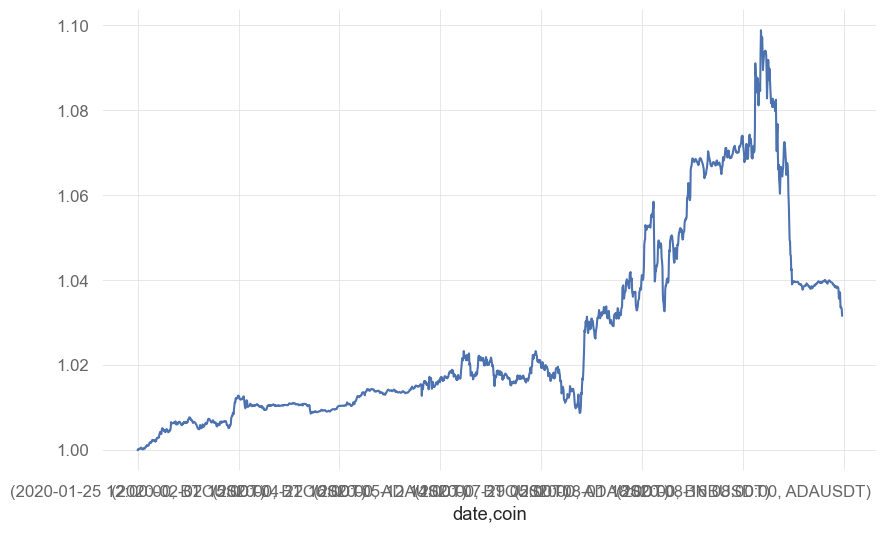

In [97]:
all_results['cstrategy'] = creturns = (all_results['strategy'] * (1/4)).cumsum().apply(np.exp)
creturns.plot()